Copyright 2020 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

This file incorporates work covered by the following copyright and  
permission notice:  

MIT License

Copyright (c) 2016-2019 Udacity, Inc.

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

# Project 2: Advanced Lane Finding

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import functools
import glob
import logging
import os

import cv2
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import numpy as np
from PIL import Image
from skimage import metrics as skmetrics

from lanefinder import camera
from lanefinder import pipeline
from lanefinder import measure
from lanefinder import transforms
from lanefinder import types
from lanefinder import utils
from lanefinder import viz

In [3]:
%matplotlib inline

default_figsize=(10, 10)
matplotlib.rcParams.update({'figure.figsize': default_figsize})
matplotlib.rcParams.update({'font.size': 14})


In [4]:
output_dir = 'output_images'

## 1. Compute camera calibration matrix and distortion coefficients

### Find corners on a sample chessboard image

In [5]:
nx = 9
ny = 6
image_dir = './camera_cal'

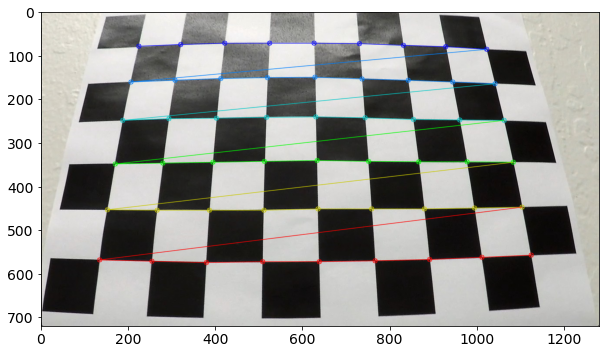

In [6]:
image_file = os.path.join(image_dir, 'calibration3.jpg')

chess_img = mpimg.imread(image_file)
drawn_img = np.copy(chess_img)
gray = cv2.cvtColor(chess_img, cv2.COLOR_RGB2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
if ret:
  cv2.drawChessboardCorners(drawn_img, (nx, ny), corners, ret)
  plt.imshow(drawn_img)
else:
  print('Failed to find or reorder all corners.')

### Get camera calibration parameters 

In [7]:
file_pattern = os.path.join(image_dir, 'calibration*.jpg')
ret, mtx, dist, rvecs, tvecs = camera.calibrate(file_pattern, nx, ny)
cam = types.CameraParams(mtx, dist)

## 2. Apply distortion correction on test image

### Sanity check distortion correction on a chessboard image

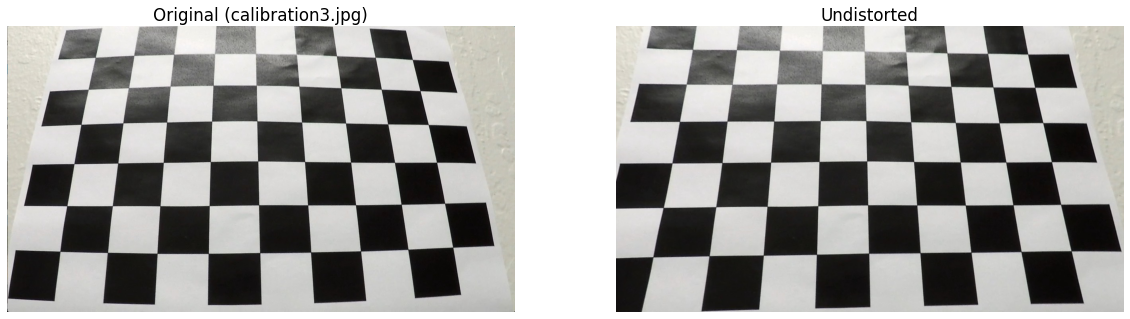

In [8]:
undist_chess_img = transforms.undistort(chess_img, cam)
viz.compare_images(
    chess_img, 
    undist_chess_img,
    in_title=f'Original ({os.path.split(image_file)[-1]})', 
    out_title='Undistorted', figsize=(20, 10))
plt.savefig(os.path.join(output_dir, 'chess_undistort_plot.png'), bbox_inches='tight')

### Correct distortion on one of the test images

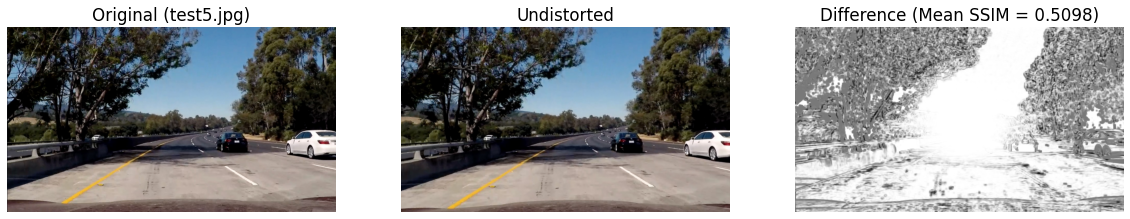

In [9]:
test_image_dir = 'test_images'
test_image_file = 'test5.jpg'
test_img = mpimg.imread(os.path.join(test_image_dir, test_image_file))
undist_img = transforms.undistort(test_img, types.CameraParams(mtx, dist))
viz.compare_images(test_img, undist_img, in_title=f'Original ({test_image_file})', out_title='Undistorted', diff=True)
plt.savefig(
    os.path.join(output_dir,  f'undistorted_{os.path.splitext(os.path.basename(test_image_file))[0]}.png'),
    bbox_inches='tight')

## 3. Create thresholded binary image using color transforms, gradients, etc.

In [10]:
binary_img = transforms.apply_thresholds(
  undist_img, pipeline.THRESHOLD_FN_MAP.values())

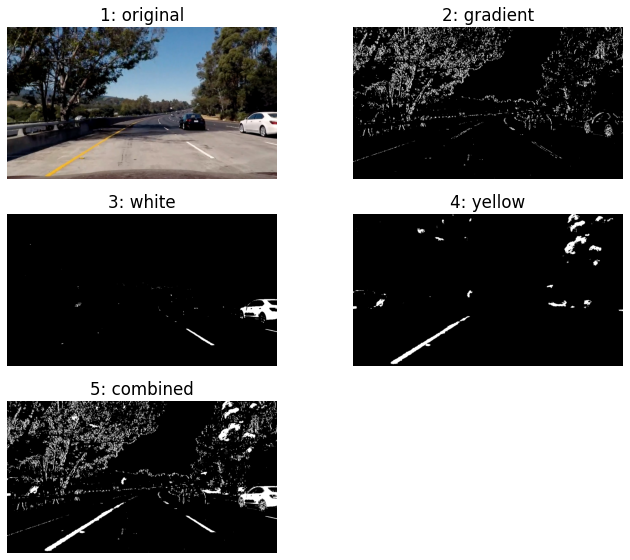

In [11]:
# Visualization

img_dict = {'original': undist_img}

for label, fn in pipeline.THRESHOLD_FN_MAP.items():
  img_dict[label] = fn(undist_img)
  
img_dict['combined'] = binary_img
  
viz.plot_images(img_dict, figsize=(10, 8))
plt.tight_layout()
plt.savefig(os.path.join(output_dir,  f'binary_threshold_plot.png'), bbox_inches='tight')

## 4. Perspective transform

### Sanity check perspective transform on a chessboard image

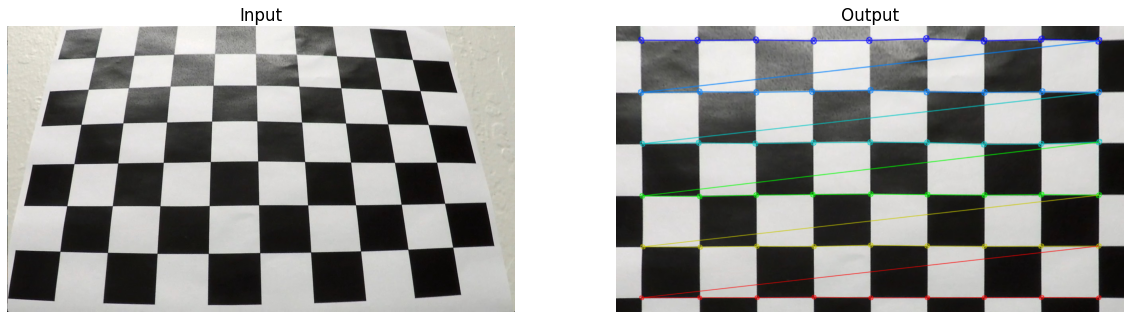

In [12]:
warped_chess_img = utils.corners_unwarp(chess_img, nx, ny, mtx, dist)
viz.compare_images(chess_img, warped_chess_img)
plt.savefig(os.path.join(output_dir,  f'warped_chess_plot.png'), bbox_inches='tight')

### Check perspective transform on the undistorted test image

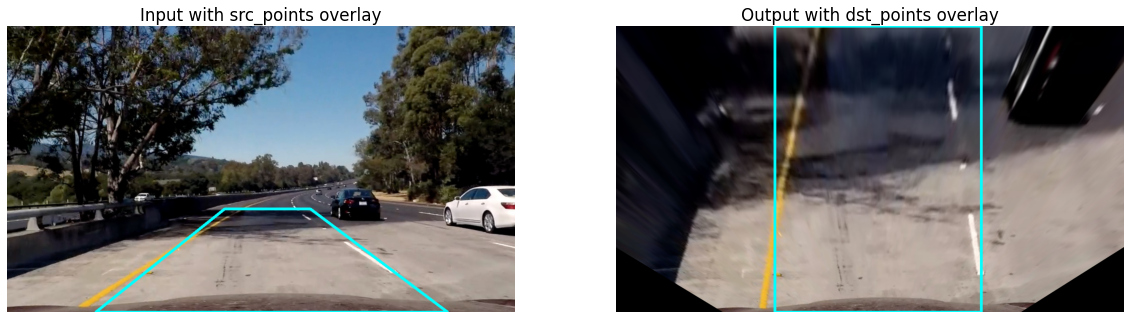

In [13]:
src_points = pipeline.WARP_PARAMS.src_points
src_img = transforms.overlay_polygon(undist_img, src_points)
dst_points = pipeline.WARP_PARAMS.dst_points
dst_img = transforms.perspective_transform(undist_img, src_points, dst_points)
dst_img = transforms.overlay_polygon(dst_img, dst_points)
viz.compare_images(
    src_img, dst_img, 
    in_title='Input with src_points overlay',
    out_title='Output with dst_points overlay')
plt.savefig(os.path.join(output_dir,  f'perspective_transform_plot.png'), bbox_inches='tight')

### Apply ROI filter on unwarped binary image

In [14]:
src_roi_img = transforms.region_of_interest(binary_img, src_points)

### Apply perspective transform on ROI filtered binary image 

In [15]:
warped_img = transforms.perspective_transform(src_roi_img, src_points, dst_points)

### Apply ROI filter to remove any remaining extraneous white pixels

In [16]:
roi_img = transforms.region_of_interest(warped_img, dst_points)

### Generate image plots 

In [17]:
binary_overlay_img = transforms.overlay_polygon(binary_img, src_points)
warped_overlay_img = transforms.overlay_polygon(warped_img, dst_points)

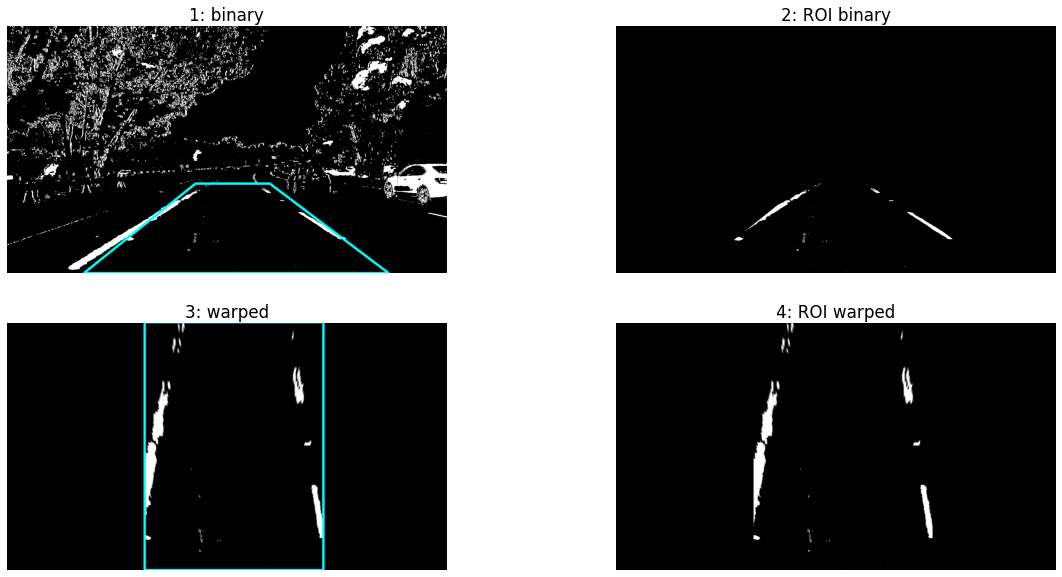

In [18]:
img_dict = {
    'binary': binary_overlay_img,
    'ROI binary': src_roi_img,
    'warped': warped_overlay_img,
    'ROI warped': roi_img,
}
viz.plot_images(img_dict, figsize=(20, 10))
plt.savefig(os.path.join(output_dir,  f'roi_image_plot.png'), bbox_inches='tight')

## 5. Detect pixels and fit to find the lane boundary

### Generate lane histogram, detect peaks for lane lines

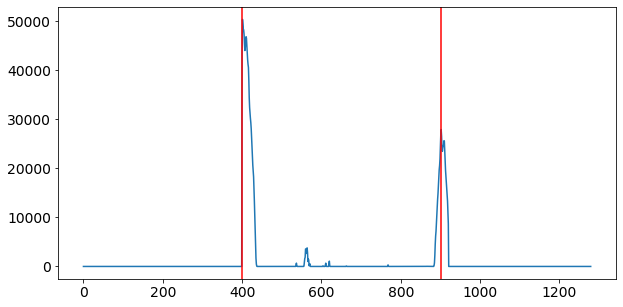

In [19]:
viz.plot_lane_histogram(roi_img, figsize=(10, 5))
plt.savefig(os.path.join(output_dir,  f'lane_histogram.png'), bbox_inches='tight')

### Find lane pixels using sliding windows

In [20]:
lp, lsr = measure.find_lane_pixels(roi_img)

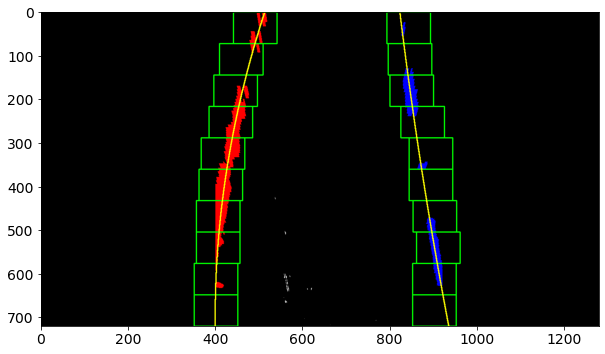

In [21]:
viz.imshow(transforms.overlay_detected_lanes(roi_img, lp, lsr))
plt.savefig(os.path.join(output_dir,  f'lane_pixels_sliding_windows.png'), bbox_inches='tight')

### Find lane boundaries from prior polynomial fit

In [22]:
margin = 50
flp = measure.fit_poly(lp)
new_lp = measure.find_lane_pixels_from_prior(roi_img, flp, margin=margin)

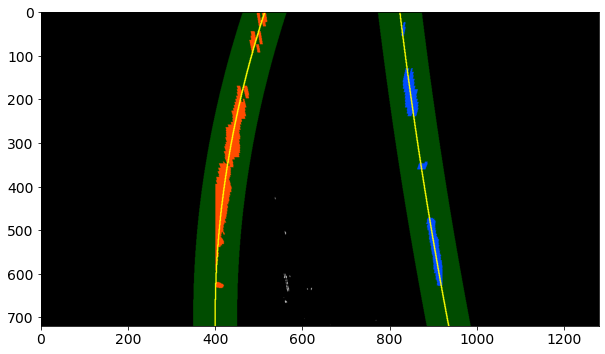

In [23]:
viz.imshow(transforms.overlay_detected_lanes(roi_img, new_lp, flp=flp, margin=margin))
plt.savefig(os.path.join(output_dir,  f'lane_pixels_prior.png'), bbox_inches='tight')

## 6. Determine curvature of the lane and vehicle position with respect to center

### Sanity check curvature calculation using dummy data 

In [24]:
ym_per_pix = pipeline.METERS_PER_PIXEL.y
xm_per_pix = pipeline.METERS_PER_PIXEL.x

ploty_, left_fit_, right_fit_ = utils.generate_data(ym_per_pix, xm_per_pix)
y_eval = np.max(ploty_)
left_curverad_ = measure.radius_of_curvature(left_fit_, ym_per_pix, y_eval)
right_curverad_ = measure.radius_of_curvature(right_fit_, ym_per_pix, y_eval)
np.testing.assert_almost_equal(left_curverad_, 533.75, decimal=2)
np.testing.assert_almost_equal(right_curverad_, 648.16, decimal=2)

### Apply curvature calculation on real-world data 

In [25]:
y_max = warped_img.shape[0]
left_fitx, right_fitx, ploty = measure.get_poly_points(flp, y_max)
left_roc, right_roc = measure.lane_curvature(
    left_fitx, right_fitx, ploty, ym_per_pix, xm_per_pix)
mean_roc = (left_roc + right_roc) / 2

print(f'left_roc={left_roc}, right_roc={right_roc}, mean_roc={mean_roc}')

left_roc=706.3805031157294, right_roc=3467.713241748595, mean_roc=2087.046872432162


### Determine vehicle position with respect to the center of the lane

In [26]:
offset = measure.vehicle_offset(undist_img, left_fitx[-1], right_fitx[-1], xm_per_pix)
relative_position = 'left' if offset < 0 else 'right'
print(f'Vehicle is {abs(offset):.2f}m {relative_position} of the center of the lane.')

Vehicle is 0.15m left of the center of the lane.


## 7. Warp detected lane boundaries back onto original image

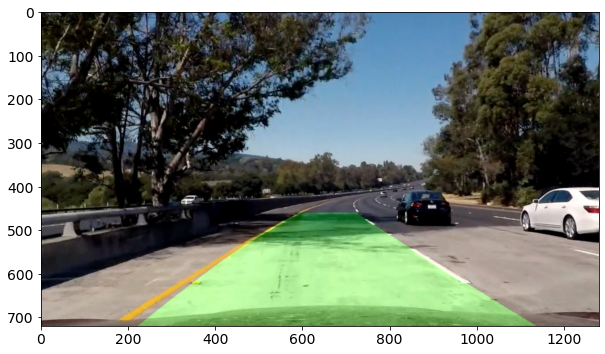

In [27]:
inv_transform_mtx = cv2.getPerspectiveTransform(dst_points, src_points)
overlay_img = transforms.overlay_lane_polygon(undist_img, flp, inv_transform_mtx)
viz.imshow(overlay_img)

## 8. Putting it all together

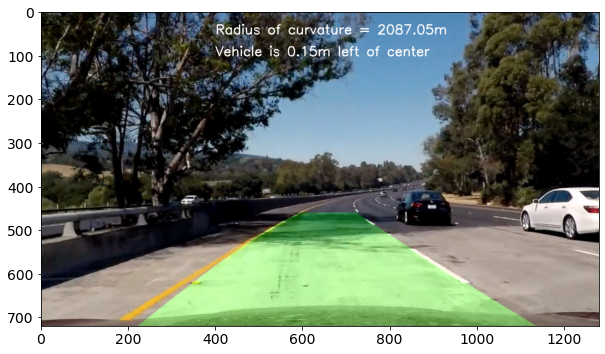

In [28]:
pipe = pipeline.Pipeline(cam)
out_img = pipe.process(test_img)
viz.imshow(out_img)
plt.savefig(os.path.join(output_dir,  f'output_test5.png'), bbox_inches='tight')

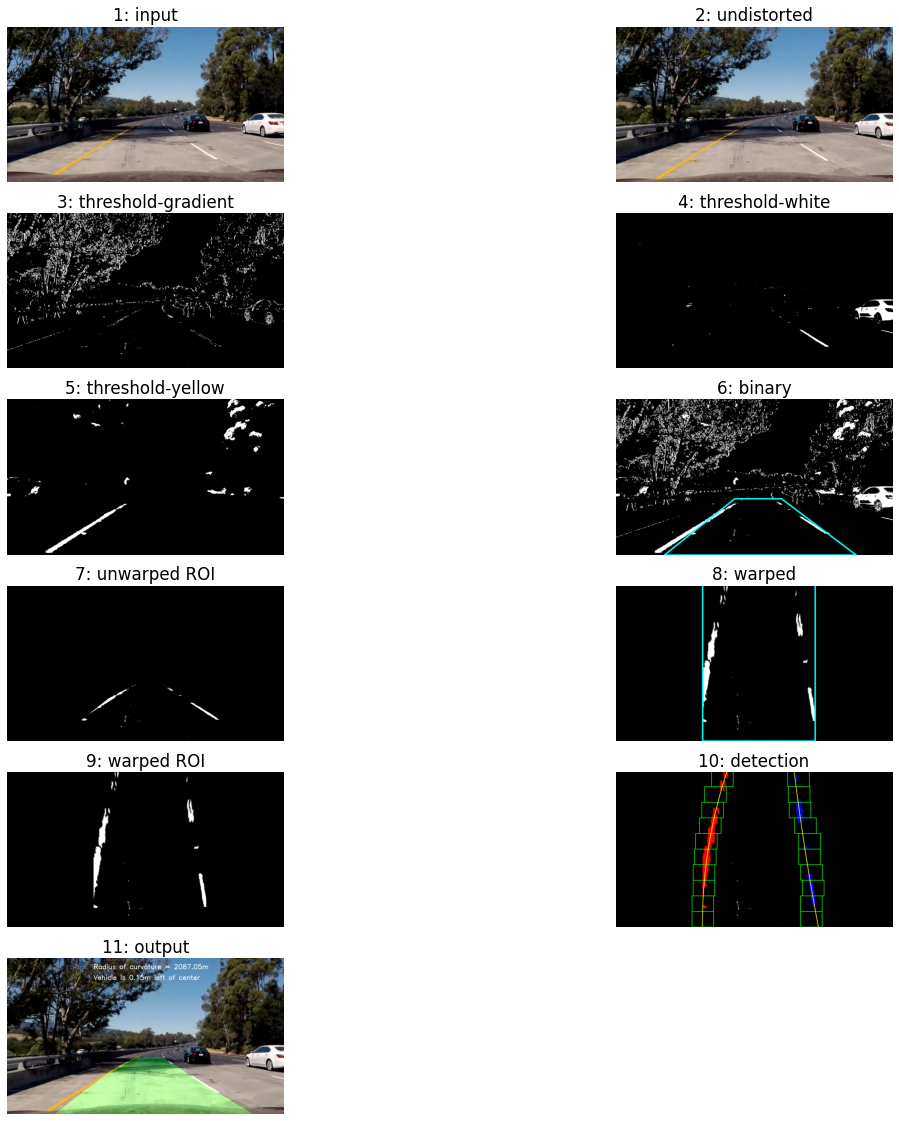

In [29]:
pipe = pipeline.Pipeline(cam)
img_dict = pipe.process(test_img, analyze=True)
viz.plot_images(img_dict)

## Run pipeline end-to-end on test images 

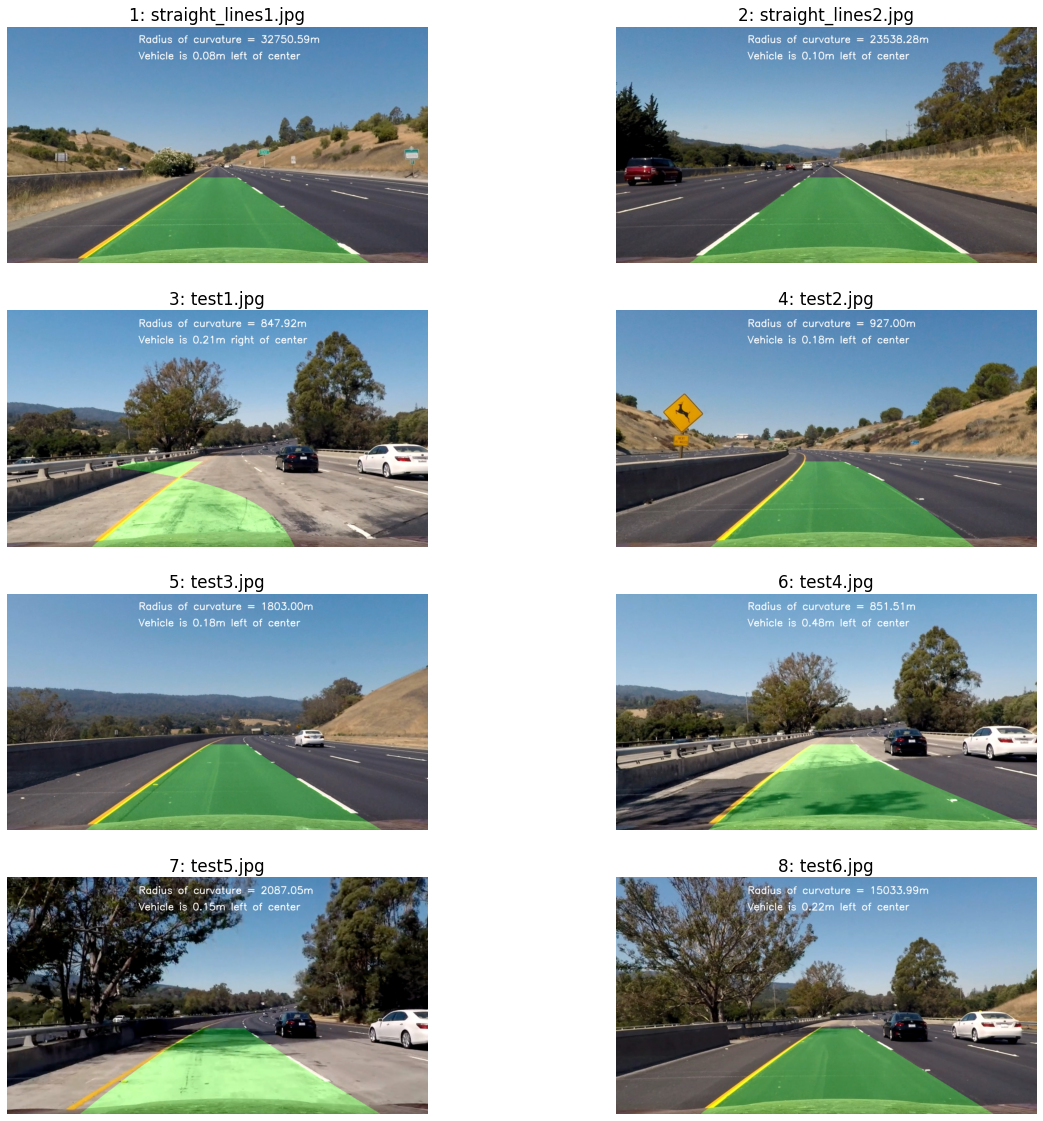

In [30]:
test_image_files = sorted(glob.glob(test_image_dir + '/*.jpg'))
output_images = {}
for f in test_image_files:
  pipe = pipeline.Pipeline(cam)
  k = os.path.split(f)[-1]
  v = pipe.process(mpimg.imread(f)) 
  output_images[k] = v
viz.plot_images(output_images)
plt.savefig(os.path.join(output_dir,  f'output_test_images.png'), bbox_inches='tight')

## Analyze one test image

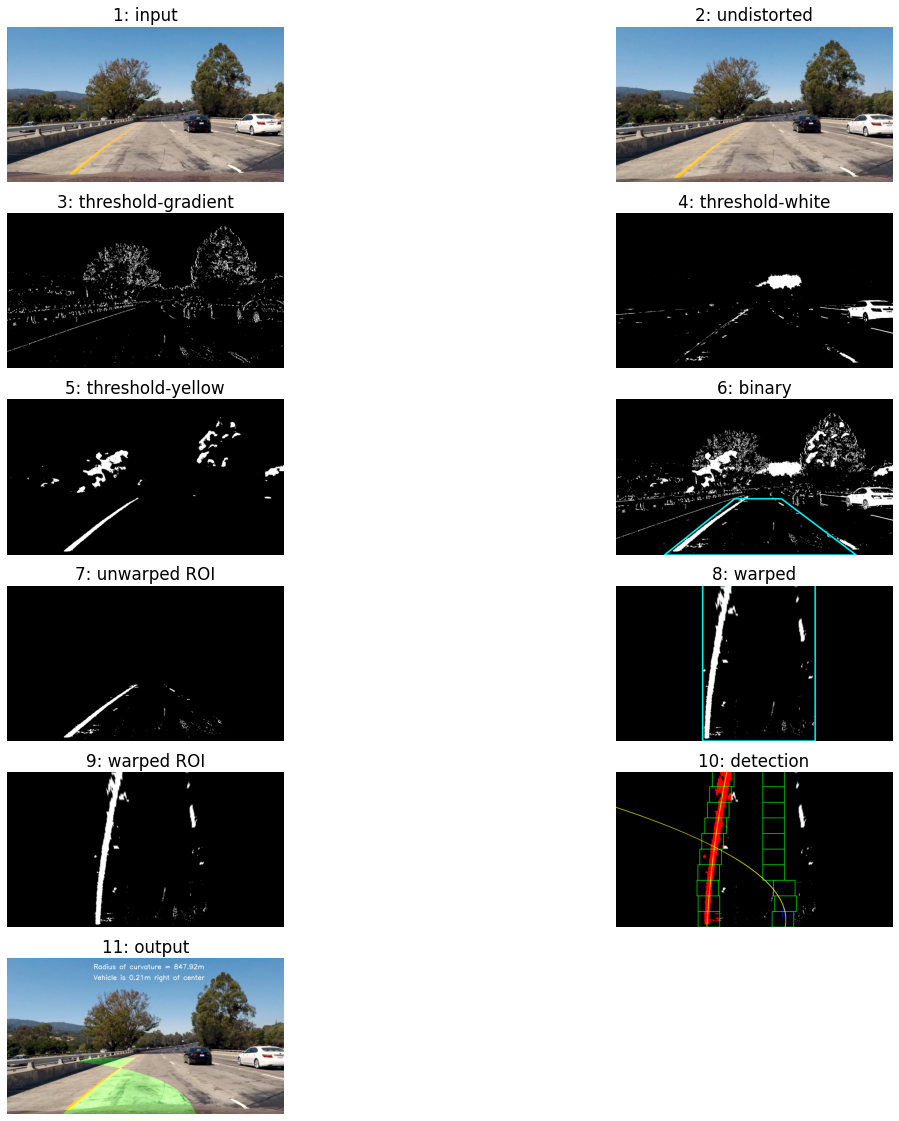

In [31]:
pipe = pipeline.Pipeline(cam)
test_image_file = os.path.join(test_image_dir,  'test1.jpg')
test_img = mpimg.imread(test_image_file)
img_dict = pipe.process(test_img, analyze=True)
viz.plot_images(img_dict)

## Run pipeline on test videos

In [32]:
from moviepy import editor
from IPython import display

In [33]:
def process_video(
    input_file: str, output_file: str, pipe: pipeline.Pipeline,
    start_sec: int = None, end_sec: int = None):
  """Runs pipeline on a video."""
  
  if start_sec is not None and end_sec is not None:
    clip = editor.VideoFileClip(input_file).subclip(start_sec, end_sec)
  else:
    clip = editor.VideoFileClip(input_file)
    
  output_clip = clip.fl_image(pipe.process)
  output_clip.write_videofile(output_file, audio=False)

### Run pipeline on project video 

In [34]:
pipe = pipeline.Pipeline(cam)
output_videos_dir = 'output_videos'
project_video_file = os.path.join(output_videos_dir, 'output_project_video.mp4')
#process_video('./project_video.mp4', project_video_file, pipe, 0, 5)
#process_video('./project_video.mp4', project_video_file, pipe)

In [35]:
display.HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_file))

### Run pipeline on challenge video

In [36]:
challenge_pipe = pipeline.Pipeline(
  cam,
  threshold_fn_map={
    'gradient': transforms.gradient_threshold,
    'white': transforms.white_threshold,
    'b_channel': functools.partial(
        transforms.channel_threshold, 
        channel=2, thresh_min=150, thresh_max=255, 
        colorspace=cv2.COLOR_RGB2LAB),
  },
  warp_params=types.WarpParams(
      src_points=np.float32([
        [223, 680],
        [548, 460],
        [764, 460],
        [1110, 680]]),
      dst_points=np.float32([
        [400, 720],
        [400, 0],
        [920, 0],
        [920, 720]]),
  )
)

In [37]:
output_videos_dir = 'output_videos'
challenge_video = './challenge_video.mp4' 
output_challenge_video = os.path.join(output_videos_dir, 'output_challenge_video.mp4')
#process_video(challenge_video, output_challenge_video, challenge_pipe, 0, 5)
#process_video(challenge_video, output_challenge_video, challenge_pipe)

In [38]:
display.HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_challenge_video))

#### Analyze challenge video 

In [39]:
t = 2
img_file = os.path.join(output_dir, f'challenge_video_frame_{t}s.jpg')
clip = editor.VideoFileClip(challenge_video)
clip.save_frame(img_file, t=t)

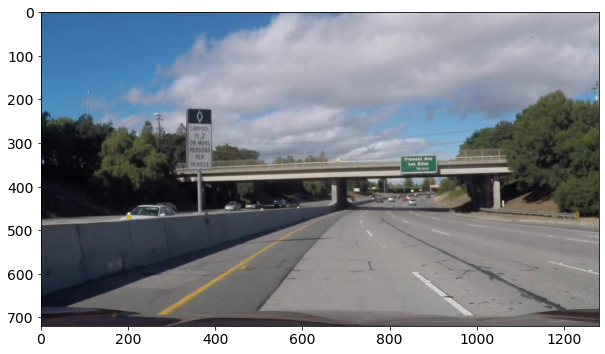

In [40]:
challenge_img = mpimg.imread(img_file)
viz.imshow(challenge_img)
plt.savefig(os.path.join(output_dir,  f'challenge_video_frame_example.png'), bbox_inches='tight')

#### Pipeline analysis

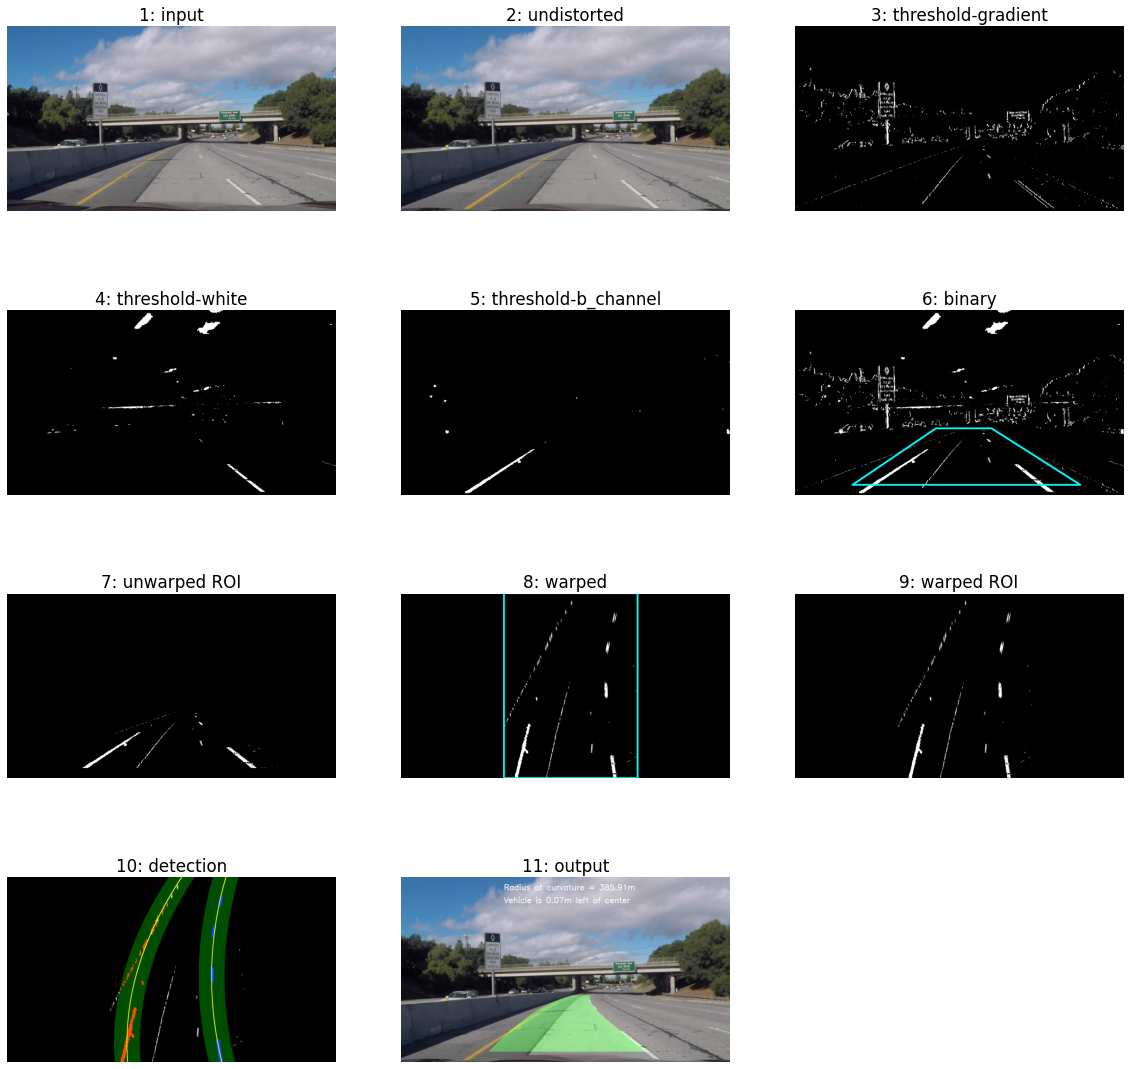

In [51]:
img_dict = challenge_pipe.process(challenge_img, analyze=True)
viz.plot_images(img_dict, cols=3)
plt.savefig(os.path.join(output_dir,  f'challenge_video_frame_pipeline_analysis.png'), bbox_inches='tight')

#### Color analysis

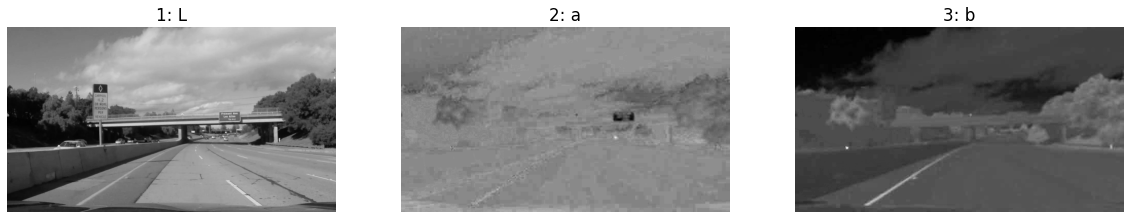

In [42]:
lab_img = cv2.cvtColor(challenge_img, cv2.COLOR_RGB2LAB)
channels = {k: v for k, v in zip(list('Lab'), np.split(lab_img, 3, axis=2))}
viz.plot_images(channels, cols=3)

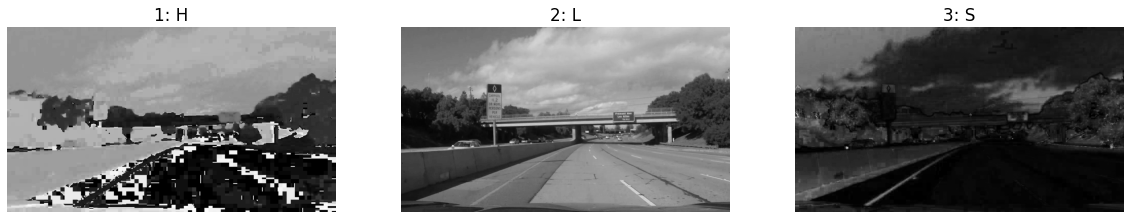

In [43]:
hls_img = cv2.cvtColor(challenge_img, cv2.COLOR_RGB2HLS)
channels = {k: v for k, v in zip(list('HLS'), np.split(hls_img, 3, axis=2))}
viz.plot_images(channels, cols=3)

### Run pipeline on harder challenge video 

In [47]:
pipe = pipeline.Pipeline(
  cam,
  threshold_fn_map={
    'gradient': transforms.gradient_threshold,
    'L_channel': functools.partial(
        transforms.channel_threshold,
        channel=0, colorspace=cv2.COLOR_RGB2LAB, thresh_min=225),
  },
  warp_params=types.WarpParams(
      src_points=np.float32([
        [100, 680],
        [400, 460],
        [764, 460],
        [1110, 680]]),
      dst_points=np.float32([
        [100, 720],
        [100, 0],
        [1020, 0],
        [1020, 720]
      ]),
  )
)

In [48]:
output_videos_dir = 'output_videos'
harder_challenge_video = './harder_challenge_video.mp4'
output_harder_challenge_video = os.path.join(output_videos_dir, 'output_harder_challenge_video.mp4')
#process_video(harder_challenge_video, output_harder_challenge_video, pipe, 0, 5)
process_video(harder_challenge_video, output_harder_challenge_video, pipe)

t:   0%|          | 3/1199 [00:00<00:48, 24.49it/s, now=None]

Moviepy - Building video output_videos/output_harder_challenge_video.mp4.
Moviepy - Writing video output_videos/output_harder_challenge_video.mp4




t:  16%|█▌        | 191/1199 [00:11<01:06, 15.19it/s, now=None]WARNING:py.warnings:/Users/cezequiel/src/adv-lane-finding/lanefinder/transforms.py:279: RankWarning: Polyfit may be poorly conditioned
  new_flp = measure.fit_poly(lp)


t:  16%|█▋        | 195/1199 [00:11<01:07, 14.93it/s, now=None]WARNING:py.warnings:/Users/cezequiel/src/adv-lane-finding/lanefinder/transforms.py:279: RankWarning: Polyfit may be poorly conditioned
  new_flp = measure.fit_poly(lp)


t:  16%|█▌        | 188/1199 [10:45<01:01, 16.50it/s, now=None] 

Moviepy - Done !
Moviepy - video ready output_videos/output_harder_challenge_video.mp4


In [49]:
display.HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_harder_challenge_video))

### Analyze harder challenge video 

In [ ]:
t = 2
img_file = os.path.join(output_dir, f'harder_challenge_video_frame_{t}s.jpg')
clip = editor.VideoFileClip(harder_challenge_video)
clip.save_frame(img_file, t=t)

In [ ]:
harder_img = mpimg.imread(img_file)
viz.imshow(harder_img)

#### Pipeline analysis 

In [ ]:
img_dict = pipe.process(harder_img, analyze=True)
viz.plot_images(img_dict, cols=3)

#### Color analysis

In [ ]:
lab_img = cv2.cvtColor(harder_img, cv2.COLOR_RGB2LAB)
channels = {k: v for k, v in zip(list('Lab'), np.split(lab_img, 3, axis=2))}
viz.plot_images(channels, cols=3)

In [ ]:
binary_img = transforms.channel_threshold(harder_img, 0, thresh_min=225, colorspace=cv2.COLOR_RGB2LAB)
viz.imshow(binary_img)

t:  16%|█▌        | 188/1199 [00:30<01:01, 16.50it/s, now=None]